In [111]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib as mpl
import collections
import matplotlib.pyplot as plt
from matplotlib import colors
import pylab as plt

from sklearn.metrics import silhouette_score
from matplotlib import colors

import numpy as np
from scipy import stats
import datetime
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


%matplotlib inline

import scipy.stats as stats

import sklearn
import statsmodels.api as sm
from sklearn import metrics

from scipy.stats import mode

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

WRITE ABOUT DATASET

In [2]:
# import the original dataset from source "https://www.kaggle.com/orgesleka/used-cars-database/"
#DataFrame "data" holds the original dataset downloaded from source
data =  pd.read_csv('C://Users//Supreetha//Box Sync//MSSE//THIRD_SEM//257_ML//datasets//used-cars-database//autos.csv',encoding='Latin1')

In [3]:
data.head(5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#Prepare our working dataset "work_data" by dropping columns and NA records to have cleaned dataset
work_data=data.drop('nrOfPictures',1)
print(data.groupby('seller').size())

seller
gewerblich         3
privat        371525
dtype: int64


In [5]:
# since the values for Seller column is one, does not make sense to have it.
work_data = work_data[work_data.seller != 'gewerblich']
work_data=work_data.drop('seller',1)
print(work_data.groupby('offerType').size())

offerType
Angebot    371513
Gesuch         12
dtype: int64


In [6]:
# Same with the column offerType, since its all single values
work_data = work_data[work_data.offerType != 'Gesuch']
work_data=work_data.drop('offerType',1)
#inspecting: name
print(len(work_data.groupby('name').size()), 'different names for all offers')

233517 different names for all offers


In [7]:
# Again, dropping name, abtest column as they are single values
work_data=work_data.drop('name',1)
work_data=work_data.drop('abtest',1)

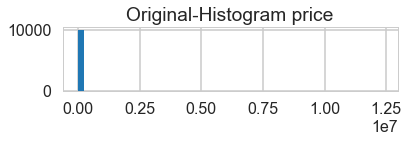

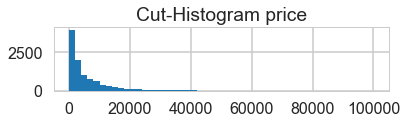

10772 cars with price 0


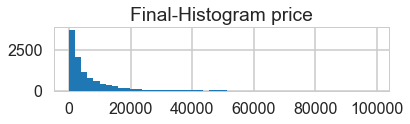

In [8]:
#sample data is temporary dataset just to analyze and plot the histogram
sample_data=work_data.sample(n=10000, random_state=1)
#inspecting: price
plt.subplot(3,1,1)
sample_data['price'].hist(bins=50)
plt.title('Original-Histogram price')
plt.show()
#There are kinda expensive cars on sale. The owners are slightly overestimating the value we guess.

# we decided to cut the price at 100000
work_data = work_data[work_data.price < 100000]
sample_data=work_data.sample(n=10000, random_state=1)

plt.subplot(3,1,2)
sample_data['price'].hist(bins=50)
plt.title('Cut-Histogram price')
plt.show()

#There are 10772 cars with price as 0, so we have to drop them
print(len(work_data[work_data.price == 0]), 'cars with price 0')
work_data = work_data[work_data.price != 0]
sample_data=work_data.sample(n=10000, random_state=1)

plt.subplot(3,1,3)
sample_data['price'].hist(bins=50)
plt.title('Final-Histogram price')
plt.show()

In [9]:
# there are lot of values which are greater than 2018 for yearOfRegistration, which makes no sense.
#dropping the values which are prior to 1863 and after 2017
work_data = work_data[(work_data.yearOfRegistration >= 1863) & (work_data.yearOfRegistration <= 2017)]
print(work_data['yearOfRegistration'].unique())

[1993 2011 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002
 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000 1992
 2013 1996 1985 1989 2015 1968 1982 1976 1983 1959 1973 1969 1971 1987
 1986 1988 1967 1980 1970 1965 1945 1925 1974 1979 1955 1978 1972 1977
 1961 1963 1964 1966 1975 1937 1936 1960 1958 1956 1933 1941 1962 1929
 1951 1957 1940 1949 1953 1935 1954 1950 1948 1952 1932 1927 1923 1931
 1942 1911 1930 1944 1943 1947 1934 1938 1928 1939 1946]


In [10]:
#remove data with engine power > 1000
print(work_data['powerPS'].describe())
work_data = work_data[(work_data.powerPS > 0) & (work_data.powerPS < 1000)]

count    356355.000000
mean        116.572558
std         186.866013
min           0.000000
25%          73.000000
50%         107.000000
75%         150.000000
max       20000.000000
Name: powerPS, dtype: float64


In [11]:
#Drop NA 
#Creating FINAL dataframe "cleaned data" for our further analysis and transformation.
cleaned_data = work_data
#dropping records which have na as they are not relvant
cleaned_data.dropna(inplace = True)
cleaned_data.head(5)

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
10,2016-03-26 19:54:18,2000,limousine,2004,manuell,105,3_reihe,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,96224,2016-04-06 10:45:34


count    247879.000000
mean        129.290077
std          62.041502
min           1.000000
25%          86.000000
50%         116.000000
75%         158.000000
max         999.000000
Name: powerPS, dtype: float64


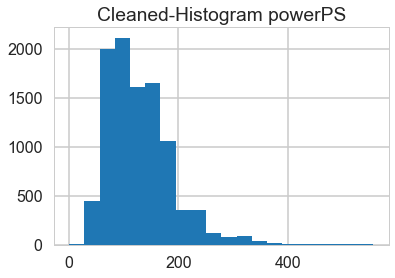

In [12]:
#Inspect powerPS column and plot it using histogram to see the distribution
column_name_you_want_to_inspect='powerPS'
print(cleaned_data[column_name_you_want_to_inspect].describe())

sample_data=cleaned_data.sample(n=10000, random_state=1)
sample_data[column_name_you_want_to_inspect].hist(bins=20)
plt.title('Cleaned-Histogram ' + column_name_you_want_to_inspect)
plt.show()

In [13]:
# ENRICHING our dataset by cleaning/standardizing/adding derived columns
pd.options.mode.chained_assignment = None
import math
#Converting date crawled to a date-time format
cleaned_data['date_crawled']= pd.to_datetime(cleaned_data['dateCrawled'])
# year registered has to be a categorical variable, so converting to STRING datatype
cleaned_data['year_registered'] = cleaned_data['yearOfRegistration'].apply(lambda x: str(x))
# month registered registered has to be a categorical variable, so converting to STRING datatype
cleaned_data['month_registered'] = cleaned_data['monthOfRegistration'].apply(lambda x: str(x))
#deriving date crawled in the correct format
cleaned_data['date_crawled_year']= cleaned_data['dateCrawled'].apply(lambda x: int(x.split('-')[0]))
#deriving the variable, HOW OLD is the car based on the crawled year vs year of Registration
cleaned_data['yearsOld'] =  cleaned_data['date_crawled_year'] - cleaned_data['yearOfRegistration'] ;

In [14]:
# Creating our target categorical variable to set if the car is expensive or not. If the price of the car is less than 
# 8000 EUR, then the car is tagged less expensive, else its set to 0
cleaned_data['less_expensive']  = cleaned_data['price'].apply(lambda x: 1 if (x <= 8000)  else 0)

In [15]:
cleaned_data.head(5)

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,...,notRepairedDamage,dateCreated,postalCode,lastSeen,date_crawled,year_registered,month_registered,date_crawled_year,yearsOld,less_expensive
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,...,nein,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,2016-03-17 16:54:04,2001,6,2016,15,1
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,...,nein,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,2016-03-31 17:25:20,2008,7,2016,8,1
5,2016-04-04 17:36:23,650,limousine,1995,manuell,102,3er,150000,10,benzin,...,ja,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,2016-04-04 17:36:23,1995,10,2016,21,1
6,2016-04-01 20:48:51,2200,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,...,nein,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,2016-04-01 20:48:51,2004,8,2016,12,1
10,2016-03-26 19:54:18,2000,limousine,2004,manuell,105,3_reihe,150000,12,benzin,...,nein,2016-03-26 00:00:00,96224,2016-04-06 10:45:34,2016-03-26 19:54:18,2004,12,2016,12,1


In [16]:
#Converting text from german to english for the column "gearbox"
cleaned_data['gearbox']=np.where(cleaned_data['gearbox']=='manuell','manual',cleaned_data['gearbox'])
cleaned_data['gearbox']=np.where(cleaned_data['gearbox']=='automatik','automatic',cleaned_data['gearbox'])
print(cleaned_data['gearbox'].unique())

['manual' 'automatic']


In [17]:
#Converting text from german to english for the column "fuelType"
cleaned_data['fuelType']=np.where(cleaned_data['fuelType']=='benzin','petrol',cleaned_data['fuelType'])
cleaned_data['fuelType']=np.where(cleaned_data['fuelType']=='elektro','electric',cleaned_data['fuelType'])
cleaned_data['fuelType']=np.where(cleaned_data['fuelType']=='andere','other',cleaned_data['fuelType'])
print(cleaned_data['fuelType'].unique())

['petrol' 'diesel' 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [18]:
#Converting text from german to english for the column "vehicleType"
cleaned_data['vehicleType']=np.where(cleaned_data['vehicleType']=='kleinwagen','smallcar',cleaned_data['vehicleType'])
cleaned_data['vehicleType']=np.where(cleaned_data['vehicleType']=='kombi','Combi',cleaned_data['vehicleType'])
cleaned_data['vehicleType']=np.where(cleaned_data['vehicleType']=='andere','other',cleaned_data['vehicleType'])
print(cleaned_data['vehicleType'].unique())

['smallcar' 'limousine' 'cabrio' 'Combi' 'suv' 'bus' 'coupe' 'other']


In [19]:
#Converting text from german to english for the column "notRepairedDamage"
cleaned_data['notRepairedDamage']=np.where(cleaned_data['notRepairedDamage']=='ja','yes',cleaned_data['notRepairedDamage'])
cleaned_data['notRepairedDamage']=np.where(cleaned_data['notRepairedDamage']=='nein','no',cleaned_data['notRepairedDamage'])
print(cleaned_data['notRepairedDamage'].unique())

['no' 'yes']


In [20]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247879 entries, 3 to 371527
Data columns (total 21 columns):
dateCrawled            247879 non-null object
price                  247879 non-null int64
vehicleType            247879 non-null object
yearOfRegistration     247879 non-null int64
gearbox                247879 non-null object
powerPS                247879 non-null int64
model                  247879 non-null object
kilometer              247879 non-null int64
monthOfRegistration    247879 non-null int64
fuelType               247879 non-null object
brand                  247879 non-null object
notRepairedDamage      247879 non-null object
dateCreated            247879 non-null object
postalCode             247879 non-null int64
lastSeen               247879 non-null object
date_crawled           247879 non-null datetime64[ns]
year_registered        247879 non-null object
month_registered       247879 non-null object
date_crawled_year      247879 non-null int64
yearsOld      

In [21]:
cleaned_data.head(5)

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,...,notRepairedDamage,dateCreated,postalCode,lastSeen,date_crawled,year_registered,month_registered,date_crawled_year,yearsOld,less_expensive
3,2016-03-17 16:54:04,1500,smallcar,2001,manual,75,golf,150000,6,petrol,...,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,2016-03-17 16:54:04,2001,6,2016,15,1
4,2016-03-31 17:25:20,3600,smallcar,2008,manual,69,fabia,90000,7,diesel,...,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,2016-03-31 17:25:20,2008,7,2016,8,1
5,2016-04-04 17:36:23,650,limousine,1995,manual,102,3er,150000,10,petrol,...,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,2016-04-04 17:36:23,1995,10,2016,21,1
6,2016-04-01 20:48:51,2200,cabrio,2004,manual,109,2_reihe,150000,8,petrol,...,no,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,2016-04-01 20:48:51,2004,8,2016,12,1
10,2016-03-26 19:54:18,2000,limousine,2004,manual,105,3_reihe,150000,12,petrol,...,no,2016-03-26 00:00:00,96224,2016-04-06 10:45:34,2016-03-26 19:54:18,2004,12,2016,12,1


Text(0.5,1,'Boxplot of price  by Less or More Expensive classifier')

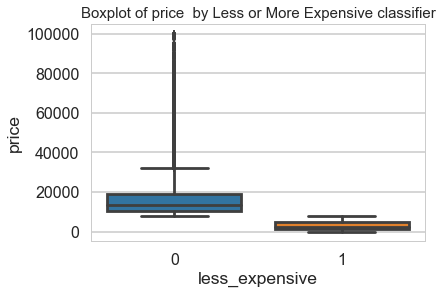

In [22]:
# plotting a box plot to see the variation of price for classifier expensive or not
seaborn.boxplot( x = 'less_expensive', y = 'price', data = cleaned_data, orient = 'v' )
plt.title( "Boxplot of price  by Less or More Expensive classifier", fontsize = 15)

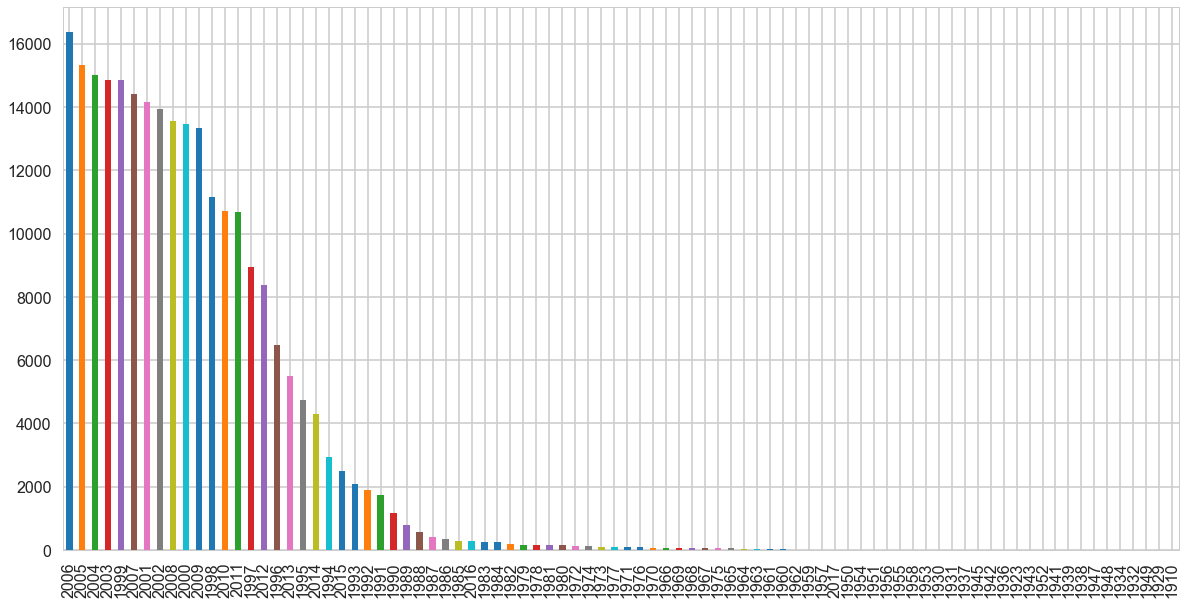

In [23]:
# Created this dataset "count_of_car_by_year" to display the count of cars against the year of registration 
# we can see that 85-90% of the cars listed are registered between 2004 to 2012
count_of_car_by_year=cleaned_data[['yearOfRegistration','brand']]
count_of_car_by_year['yearOfRegistration'].value_counts().plot(kind='bar',figsize=(20,10))
#print(count_of_car_by_year['yearOfRegistration'].value_counts().sort_values())

C:\Users\Supreetha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Supreetha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


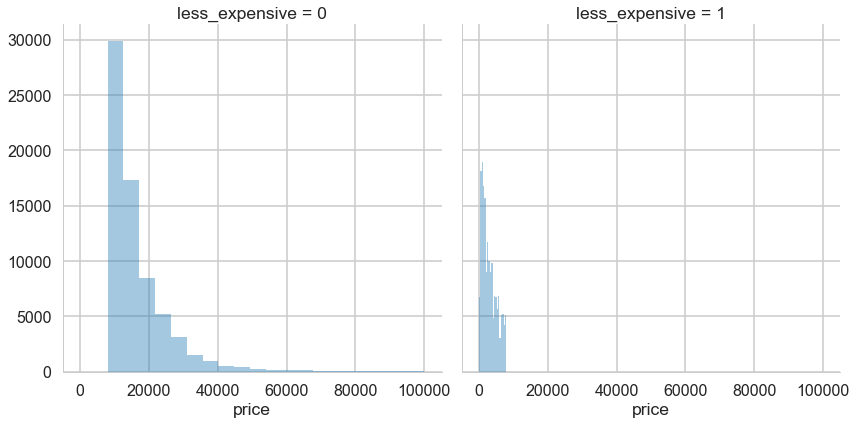

In [24]:
# g is the dataset that holds data from original "cleaned data" against the price considering the classifier variable
# we can see that there are more expensive cars listed than the less expensive one's
g = seaborn.FacetGrid(cleaned_data, col="less_expensive", size = 6)
g.map(seaborn.distplot, "price", kde = False, bins = 20 )

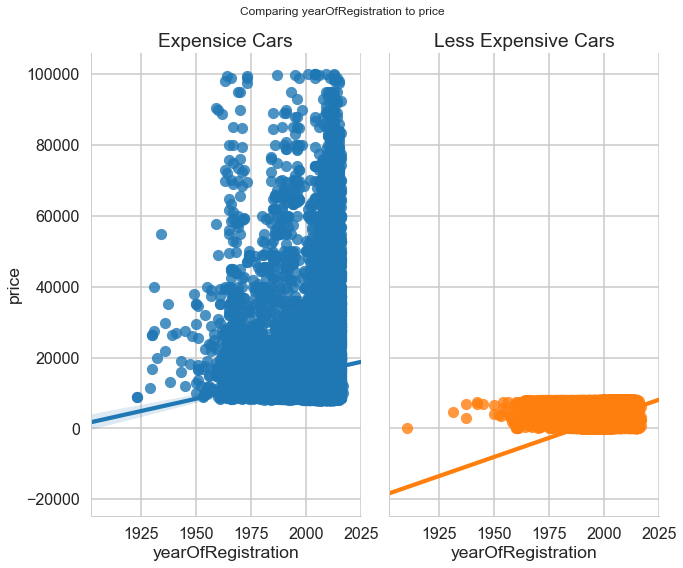

In [25]:
# creating a implot to show the variation of price against year of registration
# we can clearly see that more recent is the car, more expensive it is from this data
yearOfRegistration_vs_price_plots = seaborn.lmplot(x='yearOfRegistration', y='price', data=cleaned_data, 
                                                   hue='less_expensive', col='less_expensive', size=8, aspect=.6)
plt.subplots_adjust(top=0.9)
yearOfRegistration_vs_price_plots.fig.suptitle("Comparing yearOfRegistration to price")
yearOfRegistration_vs_price_plots.set_axis_labels("yearOfRegistration", "price")
titles=['Expensice Cars', 'Less Expensive Cars']
for ax, title in zip(yearOfRegistration_vs_price_plots.axes.flat, titles):
    ax.set_title(title)

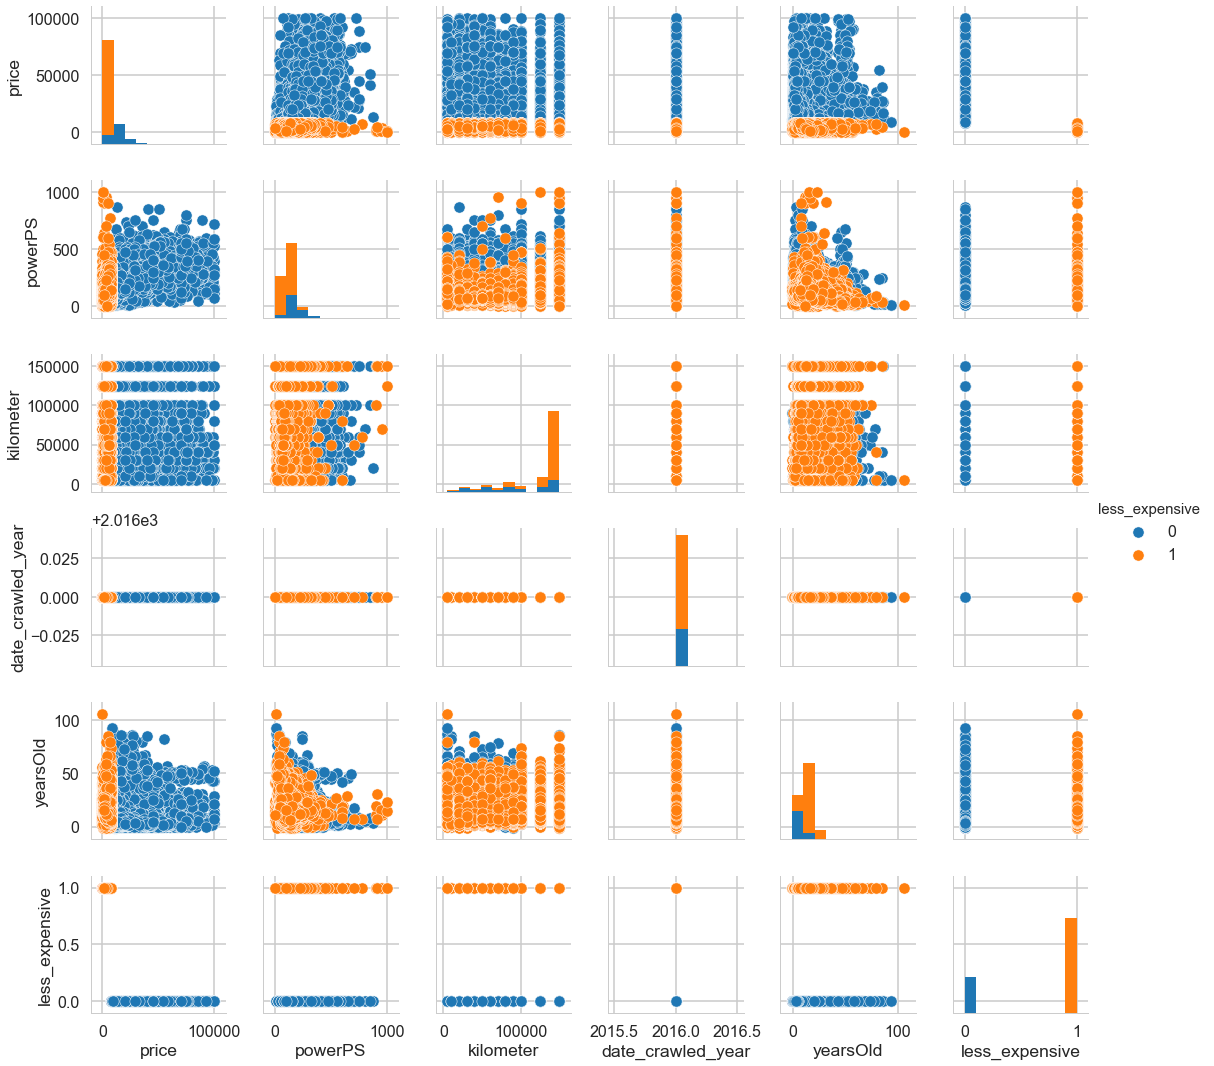

In [26]:
# Created this subset "cleaned_data_numeric" to display pairplot of numeric data to see the distribution
cleaned_data_numeric=cleaned_data[['price','powerPS','kilometer','date_crawled_year',
                                   'yearsOld','less_expensive']]
sns.pairplot(cleaned_data_numeric,hue = 'less_expensive')

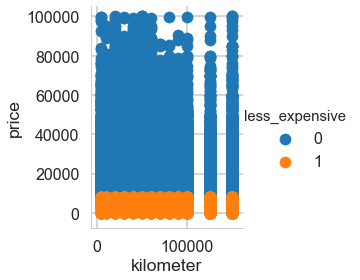

In [27]:
# Lets analyze the numerical data based on our categorical classification of whether car is expensive or not
# less_expensive if 1 otherwise it is an expensive car if 0
sns.FacetGrid(cleaned_data_numeric, hue="less_expensive", size=4) \
   .map(plt.scatter, "kilometer","price") \
   .add_legend();

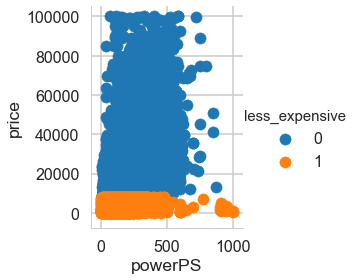

In [28]:
# scatter plot for powerPS vs price. 
# we can see that extreme high values for powerPS are for less expensive cars. Must be bad data
sns.FacetGrid(cleaned_data_numeric, hue="less_expensive", size=4) \
   .map(plt.scatter, "powerPS","price") \
   .add_legend();

In [29]:
# Some of the columns have been converted to STRING and hence original INTEGER columns are no longer needed
# So created final dataset "super_cleaned_data"
super_cleaned_data=cleaned_data
super_cleaned_data.head(5)

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,...,notRepairedDamage,dateCreated,postalCode,lastSeen,date_crawled,year_registered,month_registered,date_crawled_year,yearsOld,less_expensive
3,2016-03-17 16:54:04,1500,smallcar,2001,manual,75,golf,150000,6,petrol,...,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,2016-03-17 16:54:04,2001,6,2016,15,1
4,2016-03-31 17:25:20,3600,smallcar,2008,manual,69,fabia,90000,7,diesel,...,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,2016-03-31 17:25:20,2008,7,2016,8,1
5,2016-04-04 17:36:23,650,limousine,1995,manual,102,3er,150000,10,petrol,...,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,2016-04-04 17:36:23,1995,10,2016,21,1
6,2016-04-01 20:48:51,2200,cabrio,2004,manual,109,2_reihe,150000,8,petrol,...,no,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,2016-04-01 20:48:51,2004,8,2016,12,1
10,2016-03-26 19:54:18,2000,limousine,2004,manual,105,3_reihe,150000,12,petrol,...,no,2016-03-26 00:00:00,96224,2016-04-06 10:45:34,2016-03-26 19:54:18,2004,12,2016,12,1


In [30]:
super_cleaned_data=super_cleaned_data.drop('dateCrawled',1)
super_cleaned_data=super_cleaned_data.drop('yearOfRegistration',1)
super_cleaned_data=super_cleaned_data.drop('monthOfRegistration',1)
super_cleaned_data.head(5)

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen,date_crawled,year_registered,month_registered,date_crawled_year,yearsOld,less_expensive
3,1500,smallcar,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,2016-03-17 16:54:04,2001,6,2016,15,1
4,3600,smallcar,manual,69,fabia,90000,diesel,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,2016-03-31 17:25:20,2008,7,2016,8,1
5,650,limousine,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,2016-04-04 17:36:23,1995,10,2016,21,1
6,2200,cabrio,manual,109,2_reihe,150000,petrol,peugeot,no,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,2016-04-01 20:48:51,2004,8,2016,12,1
10,2000,limousine,manual,105,3_reihe,150000,petrol,mazda,no,2016-03-26 00:00:00,96224,2016-04-06 10:45:34,2016-03-26 19:54:18,2004,12,2016,12,1


In [31]:
super_cleaned_data.columns

Index(['price', 'vehicleType', 'gearbox', 'powerPS', 'model', 'kilometer',
       'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'postalCode',
       'lastSeen', 'date_crawled', 'year_registered', 'month_registered',
       'date_crawled_year', 'yearsOld', 'less_expensive'],
      dtype='object')

Clustering

    K-Means

    Data Story
    

In [32]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247879 entries, 3 to 371527
Data columns (total 21 columns):
dateCrawled            247879 non-null object
price                  247879 non-null int64
vehicleType            247879 non-null object
yearOfRegistration     247879 non-null int64
gearbox                247879 non-null object
powerPS                247879 non-null int64
model                  247879 non-null object
kilometer              247879 non-null int64
monthOfRegistration    247879 non-null int64
fuelType               247879 non-null object
brand                  247879 non-null object
notRepairedDamage      247879 non-null object
dateCreated            247879 non-null object
postalCode             247879 non-null int64
lastSeen               247879 non-null object
date_crawled           247879 non-null datetime64[ns]
year_registered        247879 non-null object
month_registered       247879 non-null object
date_crawled_year      247879 non-null int64
yearsOld      

In [33]:
cluster_data=super_cleaned_data
cluster_data=cluster_data[(super_cleaned_data['year_registered'].str.contains("2014"))]
cluster_data=cluster_data[['price','kilometer']]
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4302 entries, 56 to 371500
Data columns (total 2 columns):
price        4302 non-null int64
kilometer    4302 non-null int64
dtypes: int64(2)
memory usage: 100.8 KB


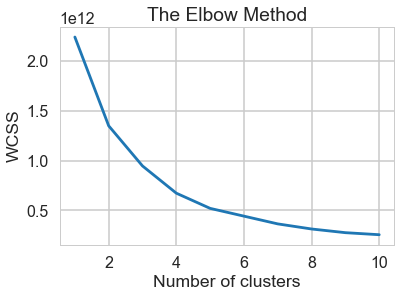

In [34]:
# Take the numerical columns and without scaling run the elbow method to determine the number of clusters

# When we took all the below numerical columns for k-means analysis, it was crashing the kernel
# So we reduced the number of columns
#X = super_cleaned_data[['price', 'powerPS','kilometer', 'yearsOld']]

# Even with two columns data, kernal was still crashing
#X = super_cleaned_data[['price','yearsOld']]

#preparing dataset just for k-means, PCA and GMM

#cluster_data=cleaned_data[(cleaned_data.yearOfRegistration >= 2015) & 
#                                (cleaned_data.yearOfRegistration <= 2017)]
#cluster_data=cleaned_data[['price','kilometer','yearsOld']]

X=cluster_data

#X.info()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
# With complete dataset, since the kernel was crashing, to ease out, we split the scaled dataset
#X_train, X_test = train_test_split(X_scaled, test_size = 0.3)

In [35]:
# Lets apply k-means on scaled data and check the silhouette score
cluster_count = 4
model = KMeans(n_clusters=cluster_count)
kmeans = model.fit(X)
label = kmeans.labels_
sil_coeff = silhouette_score(X, label, metric='euclidean')
scores = kmeans.score(X)
print (scores)
print("Number of Clusters = {}, The Silhouette Coefficient is {}".format(cluster_count, sil_coeff))

-678503396400.3076
Number of Clusters = 4, The Silhouette Coefficient is 0.4228398682513427


In [36]:
# This is to print the label per point for K-means clusters
predict_label_per_point = model.predict(X)
import collections
collections.Counter(predict_label_per_point)

Counter({3: 667, 1: 126, 0: 2405, 2: 1104})

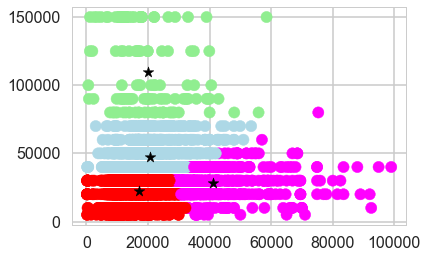

In [37]:
# There are 4 clusters, Counter({3: 667, 1: 126, 0: 2405, 2: 1104})
#price vs years Old
color_map=['red', 'lightgreen', 'lightblue','magenta']
import matplotlib.pyplot as plt
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=predict_label_per_point, 
            cmap=colors.ListedColormap(color_map))
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='*');
plt.show()

In [55]:
#above graph says optimal k is 4
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

cluster_data["cluster"] = 4-y_kmeans
cols = list(cluster_data.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


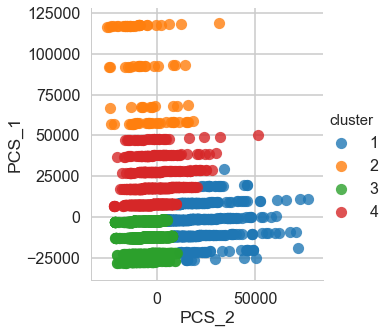

In [56]:
X = cluster_data.iloc[:, :-1]
Y = cluster_data['cluster']

from sklearn.preprocessing import StandardScaler
col_names = ['price','kilometer']
X_std = X.copy()
features = X_std[col_names]
scaler = StandardScaler().fit_transform(features.values)
X_std[col_names] = features

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

cluster_data["PCS_1"] = Y_sklearn[:,0]
cluster_data["PCS_2"] = Y_sklearn[:,1]
sns.lmplot("PCS_2","PCS_1", data=cluster_data, hue='cluster',fit_reg=False)

plt.show()

Gaussian Mixture Model

Identifying optimal number of n components using AIC/ BIC criteria

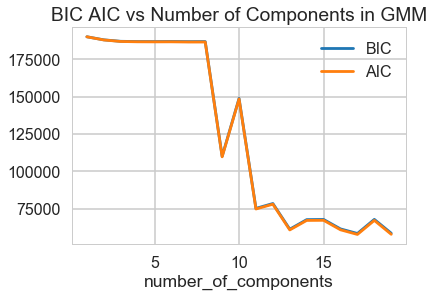

In [38]:
# By running a comparison of AIC vs BIC on our data, we come to a conclusion that number of ideal clusters would be 
gmm_models = [GaussianMixture(n_components=i,
                              covariance_type='full',max_iter=5000).fit(cluster_data.values) 
              for i in range(1,20)] 
n_components = [i for i in range(1,20)]
plt.plot(n_components, [m.bic(cluster_data.values) for m in gmm_models], label='BIC')
plt.plot(n_components, [m.aic(cluster_data.values) for m in gmm_models], label='AIC')
plt.title("BIC AIC vs Number of Components in GMM")
plt.legend(loc='best')
plt.xlabel('number_of_components');

In [39]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

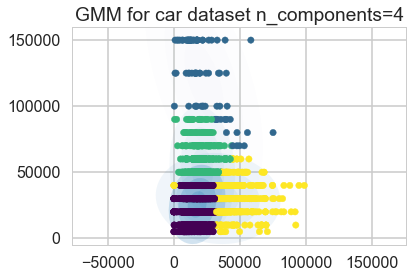

In [46]:

number_of_components=4
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=number_of_components,covariance_type='full',verbose=0,verbose_interval=10,
                      max_iter=5000).fit(cluster_data.values)
labels = gmm.predict(cluster_data.values)
test_features= ['price','kilometer']
X = cluster_data[test_features].values
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');
plt.title("GMM for car dataset n_components=4")
plot_gmm(gmm,X)

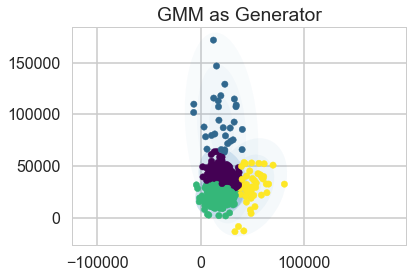

In [47]:
#density estimation using GMM as generator
gmm = GaussianMixture(n_components=number_of_components,covariance_type='full', random_state=0)
model = gmm.fit(cluster_data.values)
(genX, genY) = model.sample(500)
plt.scatter(genX[:,0], genX[:,1],c=genY,s=10,cmap='viridis')
test_features= ['price','kilometer']
X = cluster_data[test_features].values
plt.title("GMM as Generator")
genX = genX[:,[0,1]]
plot_gmm(gmm,genX)

Text(0,0.5,'kilometer')

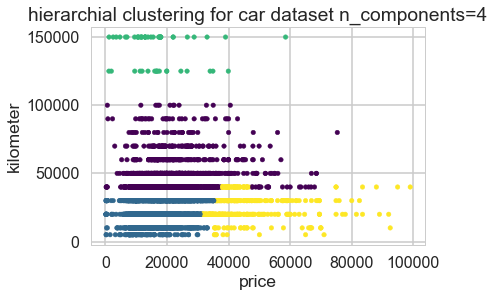

In [48]:
#Hierarchial Clustering using AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
HC = AgglomerativeClustering(n_clusters=number_of_components, linkage='ward')
HC.fit(cluster_data.values)
test_features= ['price','kilometer']
X = cluster_data[test_features].values
plt.scatter(X[:, 0], X[:, 1], c=HC.labels_, s=20, cmap='viridis');
plt.title("hierarchial clustering for car dataset n_components=4")
plt.xlabel("price")
plt.ylabel("kilometer")

Comparing silhoutte score K means, GMM, Hierarchial Clustering for 4 components

In [49]:
from sklearn.metrics import silhouette_score
silhoutte_coefficients = []
gmm = GaussianMixture(n_components=number_of_components,covariance_type='spherical',verbose=0,
                      verbose_interval=10,max_iter=5000).fit(cluster_data.values)
gmm_labels = gmm.predict(cluster_data.values)
gmm_silhoute_score = silhouette_score(cluster_data, gmm_labels, metric='euclidean')

kmeans = KMeans( init='k-means++',n_clusters=number_of_components)
kmeans_model = kmeans.fit(cluster_data)
kmeans_labels = kmeans_model.labels_
kmeans_silhoute_score = silhouette_score(cluster_data, kmeans_labels, metric='euclidean')

HC = AgglomerativeClustering(n_clusters=number_of_components, linkage='ward')
HC.fit(cluster_data.values)
HC_silhoute_score = silhouette_score(cluster_data, HC.labels_, metric='euclidean')

print ("Silhoutte score for Kmeans:",kmeans_silhoute_score, "GMM:", gmm_silhoute_score, 
       "Hierarchial Clustering:",HC_silhoute_score)

Silhoutte score for Kmeans: 0.4239666099730904 GMM: 0.4348158814657949 Hierarchial Clustering: 0.41750279570354587


Linear Regression

    Story

In [50]:
X_lin = super_cleaned_data[['kilometer']]
y_lin = super_cleaned_data[['price']]

In [51]:
# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.4, random_state=1)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.22069458511479279

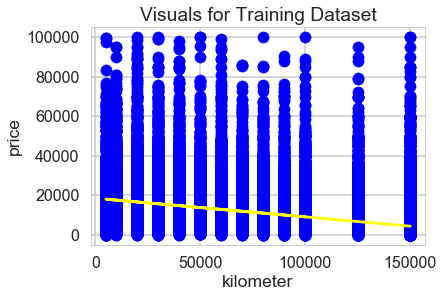

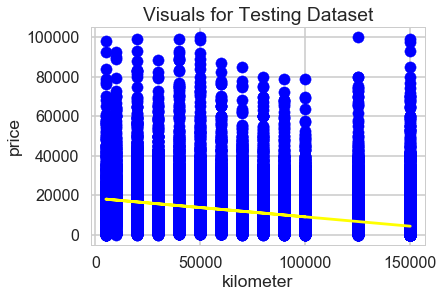

In [52]:
y_pred = reg_model.predict(X_test) 

#Visualizing the training Test Results 
plt.scatter(X_train, y_train, color= 'blue')
plt.plot(X_train, reg_model.predict(X_train), color = 'yellow')
plt.title ("Visuals for Training Dataset")
plt.xlabel("kilometer")
plt.ylabel("price")
plt.show()

#Visualizing the Test Results 
plt.scatter(X_test, y_test, color= 'blue')
plt.plot(X_train, reg_model.predict(X_train), color = 'yellow')
plt.title ("Visuals for Testing Dataset")
plt.xlabel("kilometer")
plt.ylabel("price")
plt.show()

In [54]:
lm  = LinearRegression()

#lm.fit(X_train, y_train)

model = sm.OLS(y_test, X_test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                 3.407e+04
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:18:39   Log-Likelihood:            -1.0440e+06
No. Observations:               99152   AIC:                         2.088e+06
Df Residuals:                   99151   BIC:                         2.088e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
kilometer      0.0408      0.000    184.592      0.000       0.040       0.041
==============================================================================
Omnibus:                    59899.263   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           743853.627
Skew:                           2.730   Prob(JB):                         0.00
Kurtosis:                      15.258   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# multiple linear regression

X_mlin = super_cleaned_data[['yearsOld','kilometer','powerPS']]
y_mlin = super_cleaned_data[['price']]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_mlin, y_mlin, test_size=0.4, random_state=1)

mreg_model = LinearRegression()
mreg_model.fit(X_train, y_train)
mreg_model.score(X_test, y_test)

0.590898547673133

In [57]:
model = sm.OLS(y_test,X_test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                 7.888e+04
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:19:06   Log-Likelihood:            -9.9819e+05
No. Observations:               99152   AIC:                         1.996e+06
Df Residuals:                   99149   BIC:                         1.996e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yearsOld    -119.1807      3.044    -39.157      0.000    -125.146    -113.215
kilometer     -0.0360      0.000    -87.141      0.000      -0.037      -0.035
powerPS       93.7915      0.245    382.874      0.000      93.311      94.272
==============================================================================
Omnibus:                    48065.330   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1509125.964
Skew:                           1.728   Prob(JB):                         0.00
Kurtosis:                      21.797   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Logistic Regression
    
    Story
    

Creating categorical variables using One-hot-encoding

In [58]:
print(super_cleaned_data['fuelType'].unique())

['petrol' 'diesel' 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [59]:
super_cleaned_data['gearbox_category'] = super_cleaned_data['gearbox'].apply(lambda x: 0 if (x == 'manual') else 1)


final_data = super_cleaned_data;
# there are 7 unique fuel types, we can create a categorical variable for each one of them
#array(['benzin', 'diesel', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
final_data['benzin'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'benzin') else 0)
final_data['diesel'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'diesel') else 0)
final_data['lpg'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'lpg') else 0)
final_data['other'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'other') else 0)
final_data['hybrid'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'hybrid') else 0)
final_data['cng'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'cng') else 0)
final_data['electric'] = final_data['fuelType'].apply(lambda x : 1 if (x == 'electric') else 0)

In [60]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247879 entries, 3 to 371527
Data columns (total 26 columns):
price                247879 non-null int64
vehicleType          247879 non-null object
gearbox              247879 non-null object
powerPS              247879 non-null int64
model                247879 non-null object
kilometer            247879 non-null int64
fuelType             247879 non-null object
brand                247879 non-null object
notRepairedDamage    247879 non-null object
dateCreated          247879 non-null object
postalCode           247879 non-null int64
lastSeen             247879 non-null object
date_crawled         247879 non-null datetime64[ns]
year_registered      247879 non-null object
month_registered     247879 non-null object
date_crawled_year    247879 non-null int64
yearsOld             247879 non-null int64
less_expensive       247879 non-null int64
gearbox_category     247879 non-null int64
benzin               247879 non-null int64
diesel    

In [61]:
print(super_cleaned_data['vehicleType'].unique())

['smallcar' 'limousine' 'cabrio' 'Combi' 'suv' 'bus' 'coupe' 'other']


In [62]:
# there are 8 unique vehicle types. We can create a categorical variable for each one of them
final_data['smallcar'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'smallcar') else 0)
final_data['cabrio'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'cabrio') else 0)
final_data['limousine'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'limousine') else 0)
final_data['Combi'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'Combi') else 0)
final_data['suv'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'suv') else 0)
final_data['bus'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'bus') else 0)
final_data['coupe'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'coupe') else 0)
final_data['VehicleTypeother'] = final_data['vehicleType'].apply(lambda x : 1 if (x == 'other') else 0)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247879 entries, 3 to 371527
Data columns (total 34 columns):
price                247879 non-null int64
vehicleType          247879 non-null object
gearbox              247879 non-null object
powerPS              247879 non-null int64
model                247879 non-null object
kilometer            247879 non-null int64
fuelType             247879 non-null object
brand                247879 non-null object
notRepairedDamage    247879 non-null object
dateCreated          247879 non-null object
postalCode           247879 non-null int64
lastSeen             247879 non-null object
date_crawled         247879 non-null datetime64[ns]
year_registered      247879 non-null object
month_registered     247879 non-null object
date_crawled_year    247879 non-null int64
yearsOld             247879 non-null int64
less_expensive       247879 non-null int64
gearbox_category     247879 non-null int64
benzin               247879 non-null int64
diesel    

In [63]:
# there are 35+ models, we take top models only
final_data['golf'] = final_data['model'].apply(lambda x : 1 if (x == 'golf') else 0)
final_data['fabia'] = final_data['model'].apply(lambda x : 1 if (x == 'fabia') else 0)
final_data['3er'] = final_data['model'].apply(lambda x : 1 if (x == '3er') else 0)
final_data['polo'] = final_data['model'].apply(lambda x : 1 if (x == 'polo') else 0)
final_data['corsa'] = final_data['model'].apply(lambda x : 1 if (x == 'corsa') else 0)
final_data['a4'] = final_data['model'].apply(lambda x : 1 if (x == 'a4') else 0)
final_data['passat'] = final_data['model'].apply(lambda x : 1 if (x == 'passat') else 0)
final_data['astra'] = final_data['model'].apply(lambda x : 1 if (x == 'astra') else 0)
final_data['5er'] = final_data['model'].apply(lambda x : 1 if (x == '5er') else 0)
final_data['c_klasse'] = final_data['model'].apply(lambda x : 1 if (x == 'c_klasse') else 0)

In [64]:
final_data['volkswagen'] = final_data['brand'].apply(lambda x : 1 if (x == 'volkswagen') else 0)
final_data['bmw'] = final_data['brand'].apply(lambda x : 1 if (x == 'bmw') else 0)
final_data['mercedes_benz'] = final_data['brand'].apply(lambda x : 1 if (x == 'mercedes_benz') else 0)
final_data['skoda'] = final_data['brand'].apply(lambda x : 1 if (x == 'skoda') else 0)

final_data['opel'] = final_data['brand'].apply(lambda x : 1 if (x == 'opel') else 0)
final_data['audi'] = final_data['brand'].apply(lambda x : 1 if (x == 'audi') else 0)

final_data['ford'] = final_data['brand'].apply(lambda x : 1 if (x == 'ford') else 0)
final_data['renault'] = final_data['brand'].apply(lambda x : 1 if (x == 'renault') else 0)
final_data['porsche'] = final_data['brand'].apply(lambda x : 1 if (x == 'porsche') else 0)
final_data['jaguar'] = final_data['brand'].apply(lambda x : 1 if (x == 'jaguar') else 0)


final_data['repaired'] = final_data['notRepairedDamage'].apply(lambda x : 0 if (x=='nein') else 1)
final_data['peugeot'] = final_data['brand'].apply(lambda x : 1 if (x == 'peugeot') else 0)
final_data['fiat'] = final_data['brand'].apply(lambda x : 1 if (x == 'fiat') else 0)
final_data['seat'] = final_data['brand'].apply(lambda x : 1 if (x == 'seat') else 0)
final_data['toyota'] = final_data['brand'].apply(lambda x : 1 if (x == 'toyota') else 0)
final_data['nissan'] = final_data['brand'].apply(lambda x : 1 if (x == 'nissan') else 0)
final_data['kia'] = final_data['brand'].apply(lambda x : 1 if (x == 'kia') else 0)

In [65]:
final_data['oldandheavilyUsed'] = final_data['yearsOld'] * final_data['kilometer']

final_data['oldandheavilyUsedAndDamaged'] = final_data['yearsOld'] * final_data['kilometer'] * final_data['repaired']

In [66]:
#feature scaling 

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
data.dtypes
label_field = ['less_expensive']
Y = final_data[label_field]
training_fields = ['less_expensive','powerPS', 'kilometer', 'yearsOld', 'repaired']
training_fields = ['less_expensive','oldandheavilyUsedAndDamaged','peugeot', 'kia',
                   'fiat','seat','toyota','nissan','skoda','jaguar','porsche','oldandheavilyUsed',
                   'powerPS', 'kilometer', 'yearsOld', 'gearbox_category',"benzin","diesel","lpg",
                   "other","hybrid","cng","electric","smallcar","cabrio","limousine","Combi","VehicleTypeother",
                   "suv","bus","coupe","golf","fabia","3er","polo","corsa","a4","passat","astra",
                   "5er","c_klasse","volkswagen","bmw","mercedes_benz","opel","audi","ford","renault","repaired"]
#training_fields = ['less_expensive','powerPS', 'kilometer', 'yearsOld', 'repaired']

X = final_data[training_fields]
scaled_X = scaler.fit_transform(X)
Y_label = scaler.fit_transform(Y)
Y_label = pd.DataFrame(Y_label, columns=label_field)
scaled_X = pd.DataFrame(scaled_X, columns=training_fields)
X.head()

,less_expensive,oldandheavilyUsedAndDamaged,peugeot,kia,fiat,seat,toyota,nissan,skoda,jaguar,...,5er,c_klasse,volkswagen,bmw,mercedes_benz,opel,audi,ford,renault,repaired
3,1,2250000,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,720000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,1,3150000,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,1,1800000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,1,1800000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
Y = scaled_X.less_expensive;
X_all= scaled_X[training_fields[1:]]
training_fields[1:]
len(training_fields[1:])

48

In [68]:
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(X_all, Y, test_size=0.4, random_state=0)
lm = linear_model.LogisticRegression(verbose=1)
model = lm.fit(X_train, y_train)
print (model)
predictions = lm.predict(X_test)

print ("Score:", model.score(X_test, y_test))

[LibLinear]LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)
Score: 0.907808213651767


In [69]:
predictions = lm.predict(X_test)
true_positives = 1.0
false_positives = 1.0
true_negatives = 1.0
false_negatives = 1.0
for i in range(0, len(y_test.values)):
    if (y_test.values[i] == predictions[i]):
        if (predictions[i] == 1.0):
            true_positives+=1.0
        else:
            true_negatives+=1.0
    else:
        if (predictions[i] == 1.0):
            false_positives += 1.0
        else:
            false_negatives += 1.0
            
print ("True positives:", true_positives)
print ("False positives:", false_positives)

print ("True Negatives:", true_negatives)
print ("False Negatives:", false_negatives)
prec = true_positives / (true_positives  + false_positives)
recall_score = true_positives / (true_positives  + false_negatives)
print ("precision:", prec)
print ("recall:", recall_score)
f1score = 2 * prec * recall_score / (prec + recall_score)
print ("f1score:", f1score)

True positives: 68250.0
False positives: 5820.0
True Negatives: 21763.0
False Negatives: 3323.0
precision: 0.9214256784123127
recall: 0.9535718776633647
f1score: 0.9372232101783128


Decision Tree
    
       Story

Decision Tree with criterion as gini index

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(X_all, Y, test_size=0.4, random_state=0)

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

Visualization of the Decision Tree with criterion as gini index

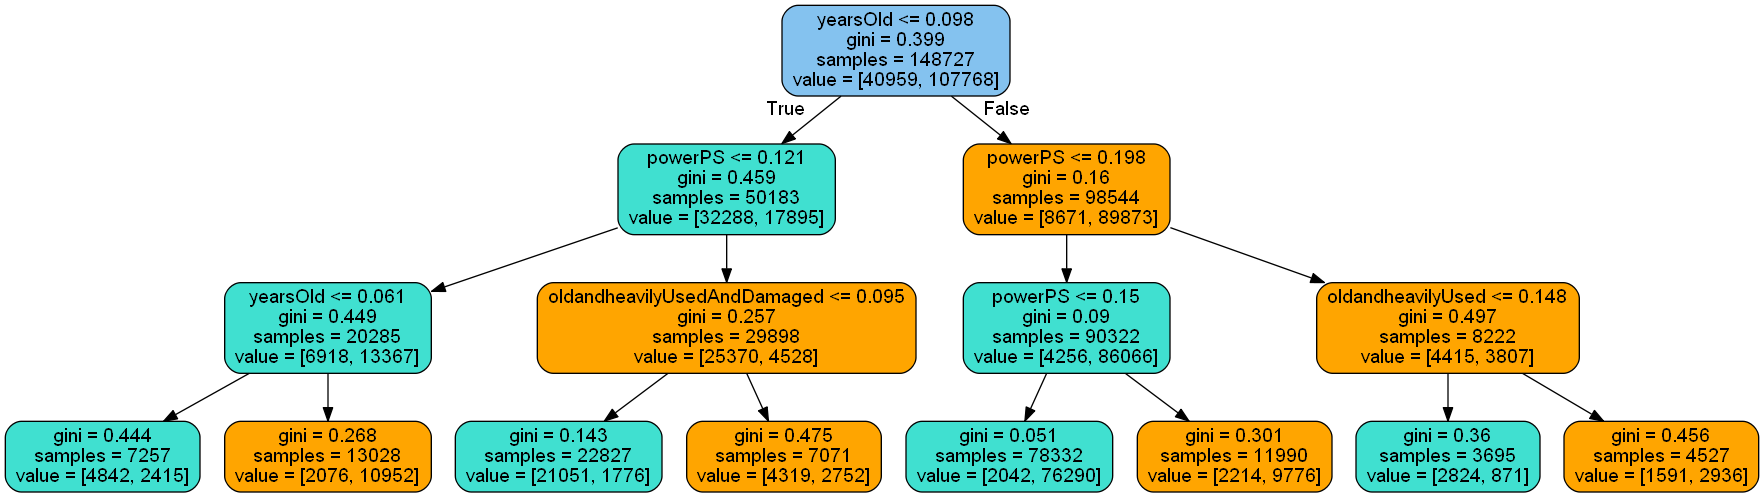

In [73]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data_feature_names=X_all.columns

dot_data = tree.export_graphviz(clf_gini,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')
Image(graph.create_png())

In [74]:
# BELOW CODE THROWING ERROR
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
#from sklearn import tree
#from sklearn.datasets import load_wine
#from IPython.display import SVG
#from graphviz import Source
#from IPython.display import display

# class labels
#labels = training_fields[1:]

#graph = Source(tree.export_graphviz(clf_gini, out_file=None
#   , feature_names=labels, class_names=['0', '1'] 
#   , filled = True))
#display(SVG(graph.pipe(format='svg')))

In [75]:
y_pred = clf_gini.predict(X_test)
y_pred

array([1., 0., 0., ..., 1., 1., 1.])

In [76]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  89.254881394223


In [77]:
predictions = clf_gini.predict(X_test)
true_positives = 1.0
false_positives = 1.0
true_negatives = 1.0
false_negatives = 1.0
for i in range(0, len(y_test.values)):
    if (y_test.values[i] == predictions[i]):
        if (predictions[i] == 1.0):
            true_positives+=1.0
        else:
            true_negatives+=1.0
    else:
        if (predictions[i] == 1.0):
            false_positives += 1.0
        else:
            false_negatives += 1.0
            
print ("True positives:", true_positives)
print ("False positives:", false_positives)

print ("True Negatives:", true_negatives)
print ("False Negatives:", false_negatives)
prec = true_positives / (true_positives  + false_positives)
recall_score = true_positives / (true_positives  + false_negatives)
print ("precision:", prec)
print ("recall:", recall_score)
f1score = 2 * prec * recall_score / (prec + recall_score)
print ("f1score:", f1score)

True positives: 66227.0
False positives: 5310.0
True Negatives: 22273.0
False Negatives: 5346.0
precision: 0.9257726770761984
recall: 0.9253070291869839
f1score: 0.9255397945636225


Decision Tree with criterion as information gain

In [78]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

Visualization of the Decision Tree with criterion as information gain

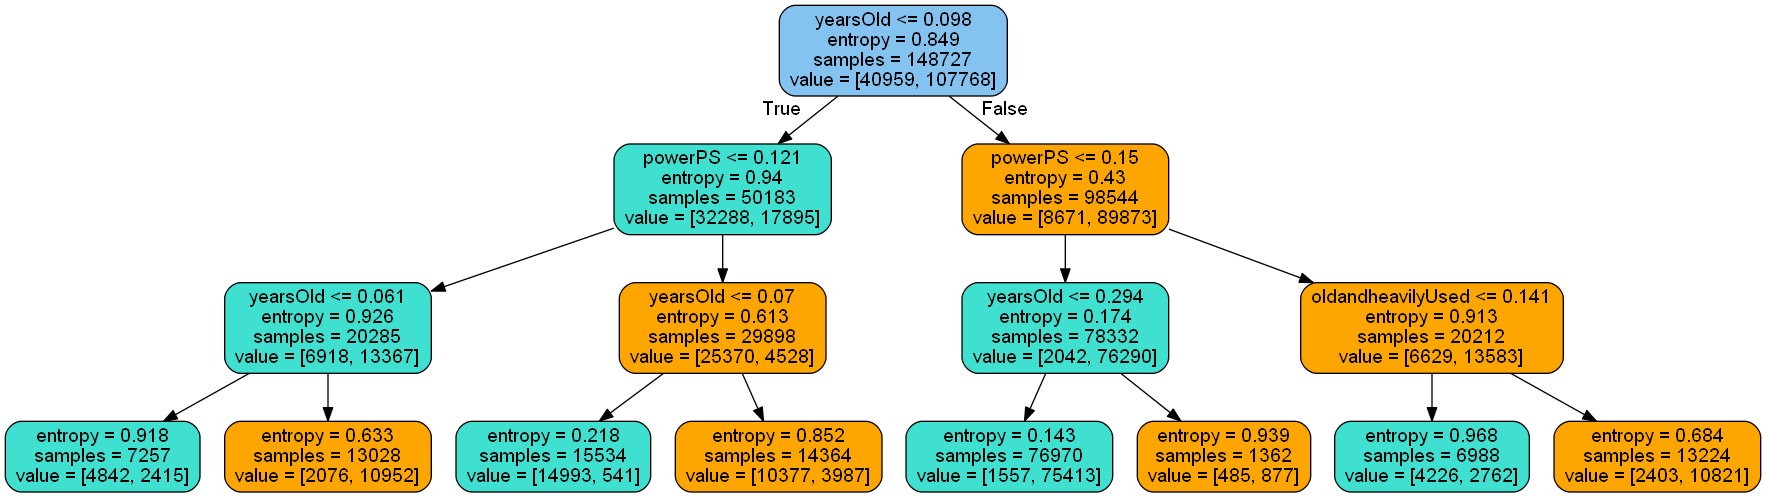

In [79]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data_feature_names=X_all.columns

dot_data = tree.export_graphviz(clf_entropy,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')
Image(graph.create_png())

In [80]:
# BELOW CODE THROWING ERROR
# class labels
#labels = training_fields[1:]

#graph = Source(tree.export_graphviz(clf_entropy, out_file=None
#   , feature_names=labels, class_names=['0', '1'] 
#   , filled = True))
#display(SVG(graph.pipe(format='svg')))

In [81]:
y_pred = clf_entropy.predict(X_test)
y_pred
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  88.85549459415847


In [82]:
predictions = clf_entropy.predict(X_test)
true_positives = 1.0
false_positives = 1.0
true_negatives = 1.0
false_negatives = 1.0
for i in range(0, len(y_test.values)):
    if (y_test.values[i] == predictions[i]):
        if (predictions[i] == 1.0):
            true_positives+=1.0
        else:
            true_negatives+=1.0
    else:
        if (predictions[i] == 1.0):
            false_positives += 1.0
        else:
            false_negatives += 1.0
            
print ("True positives:", true_positives)
print ("False positives:", false_positives)

print ("True Negatives:", true_negatives)
print ("False Negatives:", false_negatives)
prec = true_positives / (true_positives  + false_positives)
recall_score = true_positives / (true_positives  + false_negatives)
print ("precision:", prec)
print ("recall:", recall_score)
f1score = 2 * prec * recall_score / (prec + recall_score)
print ("f1score:", f1score)

True positives: 64909.0
False positives: 4388.0
True Negatives: 23195.0
False Negatives: 6664.0
precision: 0.9366783554843644
recall: 0.9068922638425104
f1score: 0.9215446865904735


Random Forests

    Story

Without Feature Importance

In [83]:
# Defining the Random Forest Classifier
RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
# TP, TN, FP , FN, Recall and F1 Score

predictions = RF.predict(X_test)
true_positives = 1.0
false_positives = 1.0
true_negatives = 1.0
false_negatives = 1.0
for i in range(0, len(y_test.values)):
    if (y_test.values[i] == predictions[i]):
        if (predictions[i] == 1.0):
            true_positives+=1.0
        else:
            true_negatives+=1.0
    else:
        if (predictions[i] == 1.0):
            false_positives += 1.0
        else:
            false_negatives += 1.0
            
print ("True positives:", true_positives)
print ("False positives:", false_positives)

print ("True Negatives:", true_negatives)
print ("False Negatives:", false_negatives)
prec = true_positives / (true_positives  + false_positives)
recall_score = true_positives / (true_positives  + false_negatives)
print ("precision:", prec)
print ("recall:", recall_score)
f1score = 2 * prec * recall_score / (prec + recall_score)
print ("f1score:", f1score)

True positives: 68512.0
False positives: 3298.0
True Negatives: 24285.0
False Negatives: 3061.0
precision: 0.954073248851135
recall: 0.9572324759336621
f1score: 0.9556502514245064


In [85]:
#Classification Report : The classification_report function builds a text report 
#showing the main classification metrics
p = RF.predict(X_test)
print(classification_report(y_test, p))

             precision    recall  f1-score   support

        0.0       0.89      0.88      0.88     27581
        1.0       0.95      0.96      0.96     71571

avg / total       0.94      0.94      0.94     99152



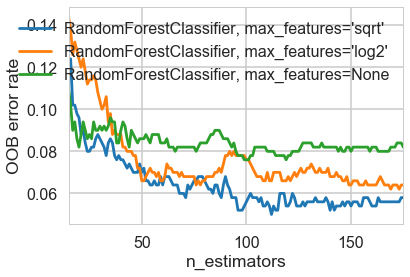

In [86]:
#Out-of-bag (OOB) error : The out-of-bag (OOB) error is the average error for each  calculated using predictions from the
# trees that do not contain  in their respective bootstrap sample. 
# This allows the RandomForestClassifier to be fit and validated whilst being trained 

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

Errors = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in Errors)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in Errors:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [87]:
#  Model Accuracy, how often is the classifier correct?
accuracy_RF = round(RF.score(X_train, y_train) * 100, 2)
accuracy_RF

96.85

Feature Importance from Random Forest

[1.50256601e-01 1.21744240e-03 1.13483519e-06 6.40706702e-04
 2.02097600e-05 9.17168379e-06 0.00000000e+00 1.24731332e-05
 1.39845045e-06 8.75432026e-03 2.01834643e-01 1.42910894e-01
 9.07125514e-02 2.11524330e-01 5.43473528e-02 0.00000000e+00
 3.51153364e-02 4.69247755e-04 1.98529065e-07 3.52076284e-05
 1.82429897e-06 1.55699197e-06 5.09914047e-02 4.32783330e-03
 3.31331071e-04 2.41557170e-04 1.24035057e-05 1.20841127e-02
 1.48558725e-04 2.47498899e-03 7.66441056e-05 5.11587715e-05
 5.59872299e-04 3.27732289e-04 1.64666177e-03 4.29806365e-05
 3.19402129e-05 2.97862377e-04 8.30910442e-04 2.28473509e-05
 1.94533427e-04 8.75718759e-03 1.73225513e-03 5.61710884e-03
 9.43352323e-03 6.95719315e-04 1.20227101e-03 0.00000000e+00]
The 10 most influencing features are
%d. feature %d (%f) (1, 'year_registered', 0.21152433032967422)
%d. feature %d (%f) (2, 'postalCode', 0.2018346431648461)
%d. feature %d (%f) (3, 'price', 0.15025660056497678)
%d. feature %d 

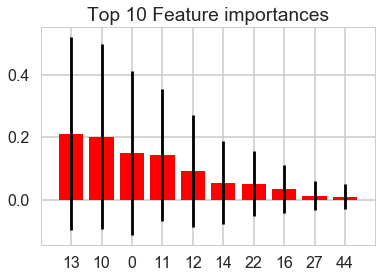

Mean Feature Importance 0.020833


In [88]:
# Run Random Forest Classification Estimator to see what the best contributing features for decision making.
from sklearn.ensemble import RandomForestClassifier
import numpy as np

estimator = RandomForestClassifier(n_estimators=300, max_depth=3, n_jobs=10)
estimator.fit(X_train,y_train) 

print ("Feature Importance from Random Forest\n")
print (estimator.feature_importances_)

importances = estimator.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0) 
indices = np.argsort(importances)[::-1]

print("The 10 most influencing features are") 
top_features = []

for f in range(10): 
    # print("%d. \t %s(%f)" % (f + 1, data_clean.columns[indices[f-1]], importances[indices[f]]))
    print("%d. feature %d (%f)",(f + 1, final_data.columns[indices[f]], importances[indices[f]]))
    top_features.append(indices[f])
    
    
print (top_features)
    
#Plot the feature importances of the forest 
indices=indices[:10] 
plt.figure() 
plt.title("Top 10 Feature importances") 
plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center") 
plt.xticks(range(10), indices) 
plt.xlim([-1, 10]) 
plt.show() 
#Mean Feature Importance 
print ("Mean Feature Importance %.6f" %np.mean(importances))

With Feature Importance

In [89]:
# Excluded the date and time related fields 
from sklearn.linear_model import LogisticRegression
columns = ['year_registered', 'postalCode', 'price', 'other',
       'month_registered', 'yearsOld', 'cabrio']

X_RF = final_data[columns]
Y_RF = final_data[label_field]

X_train, X_test, y_train, y_test = train_test_split(X_RF,Y_RF,test_size=0.4,random_state=1)

In [90]:
RF_withFeatureImp = RandomForestClassifier()
RF_withFeatureImp.fit(X_train,y_train)

C:\Users\Supreetha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
predictions = RF_withFeatureImp.predict(X_test)
true_positives = 1.0
false_positives = 1.0
true_negatives = 1.0
false_negatives = 1.0
for i in range(0, len(y_test.values)):
    if (y_test.values[i] == predictions[i]):
        if (predictions[i] == 1.0):
            true_positives+=1.0
        else:
            true_negatives+=1.0
    else:
        if (predictions[i] == 1.0):
            false_positives += 1.0
        else:
            false_negatives += 1.0
            
print ("True positives:", true_positives)
print ("False positives:", false_positives)

print ("True Negatives:", true_negatives)
print ("False Negatives:", false_negatives)
prec = true_positives / (true_positives  + false_positives)
recall_score = true_positives / (true_positives  + false_negatives)
print ("precision:", prec)
print ("recall:", recall_score)
f1score = 2 * prec * recall_score / (prec + recall_score)
print ("f1score:", f1score)

True positives: 71726.0
False positives: 1.0
True Negatives: 27428.0
False Negatives: 1.0
precision: 0.9999860582486372
recall: 0.9999860582486372
f1score: 0.9999860582486372


In [92]:
p1 = RF_withFeatureImp.predict(X_test)
print(classification_report(y_test, p1))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     27427
          1       1.00      1.00      1.00     71725

avg / total       1.00      1.00      1.00     99152



In [93]:
accuracy_RF = round(RF_withFeatureImp.score(X_train, y_train) * 100, 2)
accuracy_RF

100.0

Support Vector Machine

    Story

In [97]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
data.dtypes
label_field = ['less_expensive']
Y = final_data[label_field]
training_fields = ['less_expensive','powerPS', 'kilometer', 'yearsOld', 'repaired']
training_fields = ['less_expensive','oldandheavilyUsedAndDamaged','peugeot', 'kia',
                   'fiat','seat','toyota','nissan','skoda','jaguar','porsche','oldandheavilyUsed',
                   'powerPS', 'kilometer', 'yearsOld', 'gearbox_category',"benzin","diesel","lpg",
                   "other","hybrid","cng","electric","smallcar","cabrio","limousine","Combi","VehicleTypeother",
                   "suv","bus","coupe","golf","fabia","3er","polo","corsa","a4","passat","astra",
                   "5er","c_klasse","volkswagen","bmw","mercedes_benz","opel","audi","ford","renault","repaired"]
#training_fields = ['less_expensive','powerPS', 'kilometer', 'yearsOld', 'repaired']

X = final_data[training_fields]
scaled_X = scaler.fit_transform(X)
Y_label = scaler.fit_transform(Y)
Y_label = pd.DataFrame(Y_label, columns=label_field)
scaled_X = pd.DataFrame(scaled_X, columns=training_fields)
X.head()

Y = scaled_X.less_expensive;
X_all= scaled_X[training_fields[1:]]
training_fields[1:]
len(training_fields[1:])

X_train, X_test, y_train, y_test = train_test_split(X_all, Y, test_size=0.4, random_state=0)

In [98]:
from sklearn import svm

#Create a svm Classifier
clf_svm = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_svm.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_svm.predict(X_test)

In [99]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9161892851379699


In [100]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9301187125198874
Recall: 0.9556943454751226


K-Nearest Neighbour

    Story

In [ ]:
# Since the dataset is huge, runs forever
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

In [ ]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#We can observe above that we get maximum testing accuracy for k=# or k=#. 
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=8)

In [ ]:
#Fit the model
knn.fit(X_train,y_train)

In [ ]:
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

In [ ]:
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

Considering confusion matrix above:

True negative = #

False positive = #

True postive = #

Fasle negative = #

In [ ]:
print(classification_report(y_test,y_pred))

Naive Bayes

In [104]:
# Create categorical for vehicle type
work_data.vehicleType = pd.Categorical(work_data.vehicleType)
work_data['vehicletype_coded'] = work_data.vehicleType.cat.codes
vehicle_array = work_data['vehicletype_coded'].tolist()
vehicle_array[:5]

[6, 6, 4, 2, 4]

In [ ]:
work_data.brand.columns

In [105]:
# Create categorical for brand type
work_data.brand = pd.Categorical(work_data.brand)
work_data['brand_coded'] = work_data.brand.cat.codes
brand_array = work_data['brand_coded'].tolist()
brand_array[:5]

[37, 31, 2, 25, 19]

In [106]:
# Create categorical for model type
work_data.model = pd.Categorical(work_data.model)
work_data['model_coded'] = work_data.model.cat.codes
model_array = work_data['model_coded'].tolist()
model_array[:5]

[118, 103, 11, 8, 10]

In [107]:
input = zip(brand_array, model_array)
ilist = list(input)
ilist[:5]

[(37, 118), (31, 103), (2, 11), (25, 8), (19, 10)]

In [112]:

gnb = GaussianNB()
gnb.fit(ilist, vehicle_array)
prediction = gnb.predict([[37, 118]])
print(work_data.vehicleType[prediction])

6    cabrio
Name: vehicleType, dtype: category
Categories (8, object): [Combi, bus, cabrio, coupe, limousine, other, smallcar, suv]


In [113]:
gnb.score(ilist, vehicle_array)

0.3146736915995304